<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">

*The weight of an airframe is primarily driven by the structural loads it will experience in service. The exact range of these air loads is very hard to predict, as it is subject to a number of sources of uncertainty.*

*These uncertainties are typically handled by drawing up a conservative **flight envelope** that establishes the range of equivalent airspeeds and inertial load factors that the aircraft is to be designed for. The algorithm for drawing up the flight envelope is typically set out by the certification document that defines the initial airworthiness requirements of the aircraft to be designed. In this notebook we base our discussion of the flight envelope (and how to draw it up in ADRpy) on the algorithm included in EASA's CS-23.*

# The Flight Envelope of a Fixed Wing Aircraft

For the purposes certifying the airworthiness of an aircraft from the perspective of its structural strength, the 'flight envelope' is generally depicted as a closed set of boundaries in the V (equivalent airspeed) - n (load factor) space. The pictorial representation of this area, whithin which compliance with structural strength requirements has to be demonstrated as part of the certification process, is referred to as the **V-n diagram** of the aircraft.

The V-n diagram specifies the limit loads due to symmetrical manoeuvres and gust loads (which the airframe has to be able to withstand at any combination of equivalent airspeed and load factor within the flight envelope); other structural loads (landing, bird strike, etc.) must be dealt with separately.

In this notebook we consider the construction of V-n diagrams for 'Normal category' aeroplanes (EASA defines these as aeroplanes with a passenger seating configuration of 19 or less and a maximum certified take-off mass of 8,618kg, see CS-23.2005). Specifically, the basis of the discussion below is **CS-23** (Certification Specifications for Normal- Category Aeroplanes) **Amendment 5** / the Acceptable Means of Compliance and Guidance Material to the Certification Specifications for Normal-Category Aeroplanes (**AMC & GM to CS-23**, Issue 3). 

Let us begin with an illustrative example, which we shall use to a) demonstrate how to build a CS-23 V-n diagram in ADRpy and b) as the basis for an explanation of the anatomy of a V-n diagram.

## Illustrative example

First, we import the necessary ADRpy modules. The V-n diagram generator lives in the `airworthiness` module.

In [1]:
from ADRpy import airworthiness as aw
from ADRpy import unitconversions as co

Next, we define the inputs of the actual example. In *General Aviation Aircraft Design: Applied Methods and Procedures*, Snorri Gudmundsson puts forward a test case, a hypothetical aircraft with lightly loaded wings, designed to stretch an engineer's ability to produce more 'interesting' V-n loading diagrams. We will use this here and we define it through a set of dictionaries, which we use to instantiate an object of the `CertificationSpecifications` class.

In [2]:
designbrief = {'cruisealt_m': 0, 'cruisespeed_ktas': 107}

designdef = {'aspectratio': (38 ** 2) / 130, 'wingarea_m2': co.feet22m2(130),
                   'weight_n': co.lbf2n(1320), 'weightfractions': {'cruise': 1}}

designperf = {'CLmaxclean': 1.396, 'CLminclean': -1, 'CLslope': 6.23}

In [3]:
concept = aw.CertificationSpecifications(designbrief, designdef, designperf)

We next specify the **dive speed** $V_D$ (in KEAS, or 'knots equivalent airspeed'), the speed which, when exceeded during a dive, may result in buffeting, excessive vibration, damaging flutter or loss of control authority.

Should dive speed not be specified or be outside of the regulatory requirements, $V_D$ defaults to the minimum possible value as defined by CS-23.

In [4]:
divespeed_keas = 150

We also need to specify the wing loading at which we would like to draw up the diagram -- in this case we will use the weight and wing area embedded in the `concept` object we have just created.

In [5]:
wingload_pa = concept.acobj.weight_n / concept.acobj.wingarea_m2

Finally, we need to pick a category, as defined by CS-23. We will use 'normal' in this case, designated by the category identifier `'norm'`; the other categories are 'utility' (`'util'`), 'commuter' (`'comm'`), and 'aerobatic' (`'aero'`). The magnitude of the maneuvering loads (CS-23.337) depends on this choice - for example, aerobatic aircraft must be designed for a positive limit load factor of 6, whereas the maneuvering *n* need to be greater than 3.8 in the 'normal' and 'commuter' categories.

In [6]:
certcat = 'norm'

And now, for the main event. We plot the flight envelope for this aircraft using the `flightenvelope` method included in the`CertificationSpecifications` class. It generates the diagram and returns a dictionary containing the coordinates of all the labelled points.

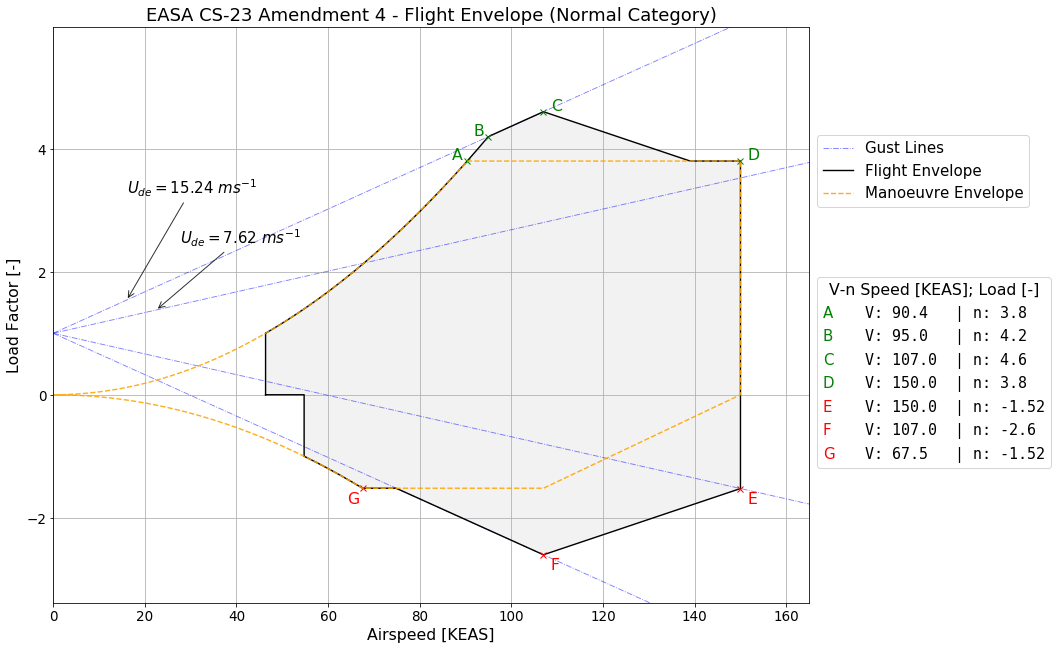

{'A': (90.35471752385638, 3.8),
 'B': (94.95299271121138, 4.196614992600004),
 'C': (106.99999424475222, 4.602180636123947),
 'D': (150, 3.8),
 'E': (150, -1.5248931050530978),
 'F': (106.99999424475222, -2.602180636123947),
 'G': (67.51861690060592, -1.52)}

In [7]:
concept.flightenvelope(wingloading_pa=wingload_pa, category=certcat, vd_keas=divespeed_keas, 
                       textsize=15, figsize_in=[15, 10], show=True)

## Anatomy of the V-n Diagram

So how was this diagram generated and how do we read it from an aircraft design point of view?

First, the V-n diagram, as shown above, superimposes the effects of manoeuvre loads (see the manoeuvre envelope traced in yellow dashed line) and gust loads (blue dashed lines).

### Defining features of the manoeuvre envelope

Let us begin in the origin of the diagram with the positive...

#### stall line.

This is the maximum normal load factor that the aircraft is capable of achieving through the deflection of its control surfaces - for any given airspeed, increasing the $C_\mathrm{L}$ and therefore the load factor $n$ is only possible up to this line, where $C_\mathrm{Lmax}$ is reached and stall will follow.

The load factor is simply the ratio of the normal accelerating resultant force acting on the aircraft and its unaccelerated weight: 

$n(V) = \frac{L}{W}=\frac{\frac{1}{2}\rho_0V^2SC_\mathrm{L}}{W}$,

which peaks when the lift coefficient 'maxes out',so:

$n_\mathrm{max}(V) = \frac{L\mathrm{max}(V)}{W} = \frac{\frac{1}{2}\rho_0V^2SC_\mathrm{Lmax}}{W} = \frac{\frac{1}{2}\rho_0V^2C_\mathrm{Lmax}}{W/S}$.


Now, with increasing equivalent airspeed, this maximum achievable load factor increases, but at a value denoted...

#### $V_\mathrm{A}$ or manoeuvre speed

...it reaches the limit load factor permitted by the certification requirements document (e.g., CS-23, paragraph 23.337) - 3.8 in the case of this example. In other words, once you have exceeded the manoeuvre speed, a full deflection of the control surfaces (if they have sufficient authority) may cause the airframe to exceed the limit load factor.

A similar logic applies to the 'negative $g$' stall line (0-G on the diagram).

The stall curves are typically 'closed off' at the 1g (or -1g) point, as in the area to the left of these points  the aircraft is not capable of generating sufficient lift to support its weight (this is literally what a sub-unity load factor means), even in steady, level flight. Somewhat colloquially the corresponding speeds are often referred to as 'the stall speeds' (normal and inverted), although we must place inverted commas around this because, technically, as this very diagram makes plain, you can stall an aeroplane at any speed if you exceed its maximum lift coefficient. 

Other significant speeds that determine the shape of both envelopes are...

#### ...the design cruise speed $V_\mathrm{C}$  and the design dive speed $V_\mathrm{D}$.

While $V_\mathrm{C}$ is, of course, related to the operationally most favourable speed of the aircraft (for example, the speed that maximises its range), this 'certification value' of the cruise speed must be chosen quite carefully because airworthiness requirements, such as CS 23.335 establish a series of quite complicated constraints and relationships between $V_\mathrm{C}$, $V_\mathrm{D}$, wing loading and so on.

When choosing $V_\mathrm{D}$, the designer must also bear in mind the various aeroealsticity-related issues of high speed flight. See, for example, the stipulations in CS 23.629, such as that *'any rational analysis used to predict freedom from flutter, control reversal and divergence must cover all speeds up to 1.2 $V_\mathrm{D}$'*

### Gust loads

Let us now consider the impact of accounting for gust loads.

These are caused by rising or sinking columns of air which the aircraft might penetrate, with the result being a temporary increase or decrease, respectively, of the angle of attack and thus the load factor. The gust-related load factor increases linearly with airspeed, which is why we see gust *lines* on the diagram (emanating from the (0,1) point). 

CS 23.333 requires that we account for positive (up) and negative (down) gusts of 50 fps (or 15.24m/s) at $V_\mathrm{C}$ at altitudes between sea level and 6,096m (20,000ft). Points C and F on the diagram indicate the load factor values calculated for +/-50fps respectively at this speed and this gives us the first pair of gust lines (CS 23.341 tells us how to calculate the gust load factor as a function of airspeed).

Similarly, positive and negative gusts of 25fps at $V_\mathrm{D}$ must be considered at altitudes below 20,000ft, which yields the next pair of gust lines.

Finally, all four lines are trimmed at $V_\mathrm{C}$ and $V_\mathrm{D}$ as appropriate and the end points of the positive pair and the negatove pair are connected with straight lines, as per the last paragraph of 23.333.

With all the key constraints and landmark points in place, the complete flight envelope can be drawn up (shown as the shaded area here). This is done by taking the more conservative of the manoeuvre and gust envelopes in each point of the V-n space.

ADRpy does this automatically, but if you're drawing your own diagram or writing your own code you may wish to look out for a few gotchas. 

An example is the tricky corner around point A, where, if the 50fps gust line does not intersect the stall curve, you have to extend the latter until it does. The abscissa of the intersection point is... 

#### ...$V_\mathrm{B}$, a.k.a, the maximum gust intensity speed

This speed is noteworthy, because above it the strongest expected gust - 50fps in this case, but may have to be assumed as high as 66fps for commuter category aircraft - could cause the aircraft to stall. A hat tip to Snorri Gudmundsson for pointing out in his GA aircraft design book that this is 'corner' does not appear in the example diagram shown in Part 23, but may well be a feature of aircraft with low wing loadings.